In this notebook, I'll try to replicate and train the network described in [this video](https://www.youtube.com/watch?v=Q1JCrG1bJ-A).


In [1]:
import tensorflow as tf

2023-12-22 22:25:57.956648: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-22 22:25:57.956690: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-22 22:25:57.957978: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-22 22:25:57.965335: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

class LivePlotCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        if epoch % 10 == 0:  # Update the plot every 10 epochs
            self.plot_loss(logs.get('loss'), epoch)
    
    def plot_loss(self, loss, epoch):
        if epoch == 0:
            self.losses = []
        
        self.losses.append(loss)
        clear_output(wait=True)
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, len(self.losses) + 1), self.losses, label='Training Loss')
        plt.title('Training Loss Over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

Matplotlib created a temporary cache directory at /tmp/matplotlib-pxda7nq4 because the default path (/home/john/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [3]:
# Let's learn a neural net that approximates a non-linear function T,
# which will take 4 inputs and return 2 outputs:
#
#   T(x1, x2, x3, x4) = (y1, y2)
#

def T(x):
    y1 = 0.3*x[0] + 0.1*x[1] + -0.2*x[2] + -0.2*x[3]
    y2 = 0.1*x[0] * 0.2*x[1] * 0.3*x[2] * -0.4*x[3]
    # return tensor as output
    return tf.stack([y1, y2])

# In order to train our model, we need training data.
# We will generate training data in the following way:
# - Generate 1000 random values for x = (x1, x2, x3, x4)
# - Plug those values into T and set y_true = T(x)
# - Sample noise from a normal distribution and set y_noise = N(mean, std)
# - Set y = y_true + y_noise
# - Add (x, y) to our training data
X = tf.random.normal(shape=(1000, 4))
Y_true = tf.stack([T(x) for x in X])
Y_noise = tf.random.normal(shape=Y_true.shape, mean=0.0, stddev=0.01)
Y = Y_true + Y_noise

# Let's also create a "test" dataset that the model will not be allowed to see during training
# This will help us determine whether we are over-fitting
X_test = tf.random.normal(shape=(1000, 4))
Y_true_test = tf.stack([T(x) for x in X])
Y_noise_test = tf.random.normal(shape=Y_true_test.shape, mean=0.0, stddev=0.01)
Y_test = Y_true_test + Y_noise_test

activation_function = tf.keras.activations.sigmoid

model = tf.keras.Sequential([
    tf.keras.layers.Dense(4, activation=activation_function),
    tf.keras.layers.Dense(3, activation=activation_function),
    tf.keras.layers.Dense(3, activation=activation_function),
    tf.keras.layers.Dense(2, activation=activation_function)
]);

# We need to select a loss function and an optimizer.
# We will use the mean squared error loss function and the adam optimizer.
loss_function = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam()

# Let's compile our model.
model.compile(optimizer=optimizer, loss=loss_function)

2023-12-22 22:26:01.525657: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-22 22:26:01.528320: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-22 22:26:01.530937: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [4]:
print("X.shape is", X.shape)
print("Y.shape is", Y.shape)

X.shape is (1000, 4)
Y.shape is (1000, 2)


In [5]:
# Let's evaluate our model (before training).
model.evaluate(X, Y)
model.evaluate(X_test, Y_test)

32/32 [==============================] - 0s 1ms/step - loss: 0.4625


0.46250906586647034

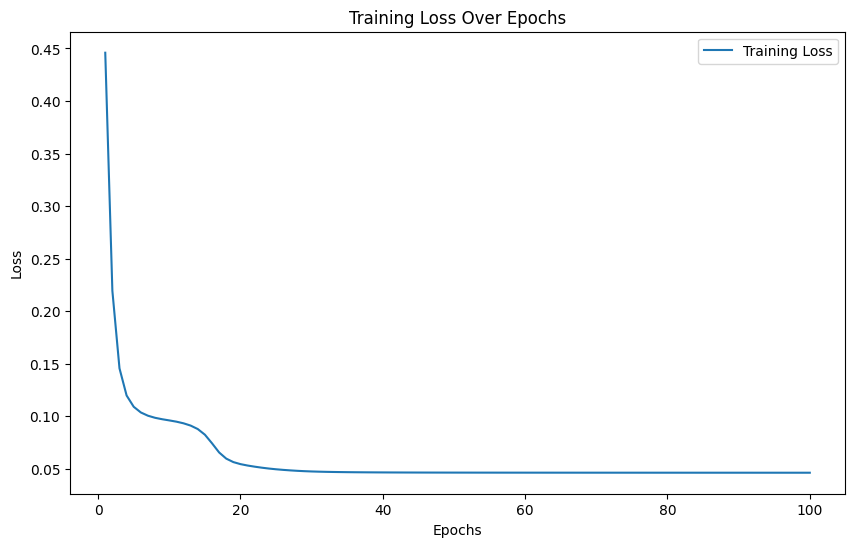

In [6]:
model.fit(X, Y, epochs=1000, verbose=0, callbacks=[LivePlotCallback()])

In [7]:
# Let's evaluate our model.
model.evaluate(X, Y)
model.evaluate(X_test, Y_test)

32/32 [==============================] - 0s 1ms/step - loss: 0.1353


0.13525187969207764

Let's check if more training will improve our model.

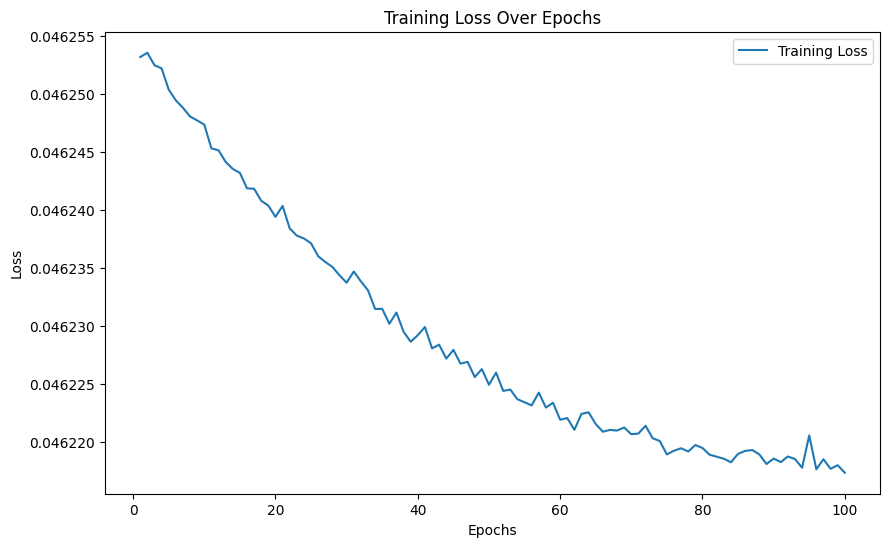

In [8]:
model.fit(X, Y, epochs=1000, verbose=0, callbacks=[LivePlotCallback()])

In [9]:
# Let's evaluate our model.
model.evaluate(X, Y)
model.evaluate(X_test, Y_test)

32/32 [==============================] - 0s 1ms/step - loss: 0.1348


0.13476142287254333

It appears that we were not able to improve the model with more training.

When we look at the first training graph, we can see that the loss stopped moving as quickly around 0.1. This is likely when the model reached its most generalizable state. Beyond this point, it seems that the model is likely over-fitting.

Running the training process again with just 1/10th the number of epochs yields similar results, as we'll show in the next cells.

In [10]:
activation_function = tf.keras.activations.sigmoid

model = tf.keras.Sequential([
    tf.keras.layers.Dense(4, activation=activation_function),
    tf.keras.layers.Dense(3, activation=activation_function),
    tf.keras.layers.Dense(3, activation=activation_function),
    tf.keras.layers.Dense(2, activation=activation_function)
]);

# We need to select a loss function and an optimizer.
# We will use the mean squared error loss function and the adam optimizer.
loss_function = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam()

# Let's compile our model.
model.compile(optimizer=optimizer, loss=loss_function)

In [11]:
model.evaluate(X, Y)
model.evaluate(X_test, Y_test)

32/32 [==============================] - 0s 1ms/step - loss: 0.4004


0.40039288997650146

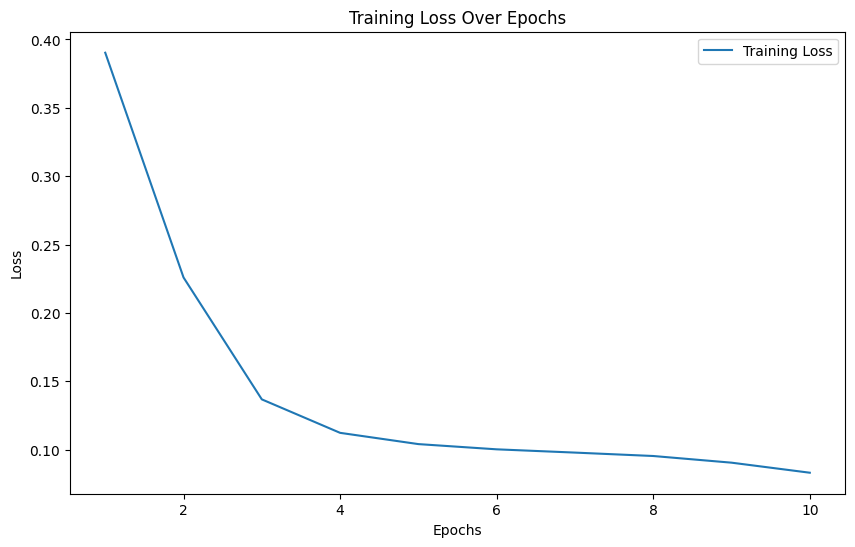

In [12]:
model.fit(X, Y, epochs=100, verbose=0, callbacks=[LivePlotCallback()])

In [13]:
model.evaluate(X, Y)
model.evaluate(X_test, Y_test)

32/32 [==============================] - 0s 1ms/step - loss: 0.1050


0.1049588993191719

We an even better score (on the test set) than the previous training example. Let's see if training more will worsen the score (because it will allow the model to overfit).

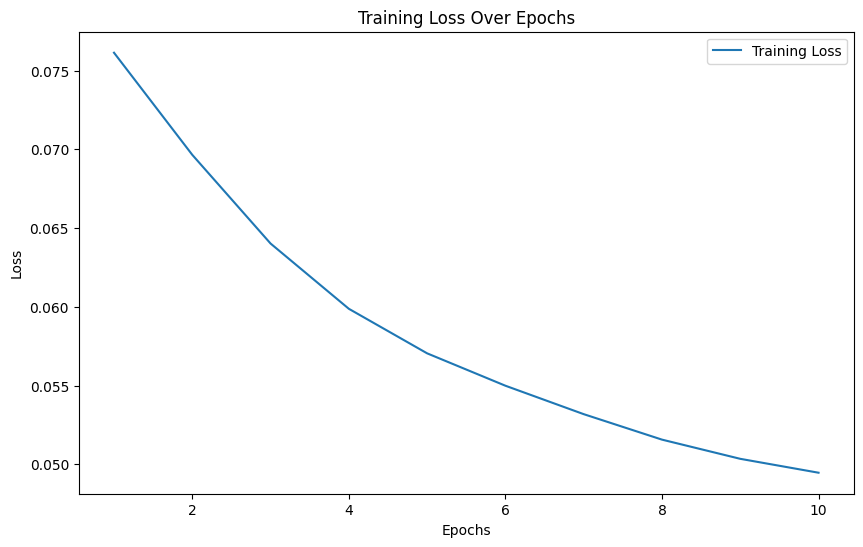

In [14]:
model.fit(X, Y, epochs=100, verbose=0, callbacks=[LivePlotCallback()])

In [15]:
model.evaluate(X, Y)
model.evaluate(X_test, Y_test)

32/32 [==============================] - 0s 1ms/step - loss: 0.1301


0.13013841211795807

As we can see from the evaluation, our model fit its training data better, but was *worse* at generalizing to the test data.